In [1]:
import math
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib
from matplotlib import rc
from collections import defaultdict

In [2]:
probe_folders = ["/data/horse/ws/lama722b-nanite-lm/dumps/mup_debug/"]
rc("animation", html="jshtml")

In [3]:
DEFAULT_QUANTILES = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]
DATAS_PER_FILE = {}
datas = []
NUM_LAYERS = 2  # TODO: Deduce from files
COLORS = [f"tab:{x}" for x in ["blue", "orange", "green", "red"]]

In [4]:
for f in probe_folders:
    name = Path(f).name
    print("Loading ", name)
    file = None
    for probe_test in ["probe/probe.0.jsonl", "probe.json"]:
        if (Path(f) / probe_test).exists():
            file = Path(f) / probe_test
    assert file is not None, "Could not find probe json file"
    data = file.read_text()
    datas = []
    for line in data.splitlines():
        if line == "":
            continue
        datas.append(json.loads(line))
        datas[-1].setdefault("quantiles", DEFAULT_QUANTILES)

    DATAS_PER_FILE[name] = datas
    # Assumes layers have the form
    # `FSDP.module.blocks.{LAYER_NUM}...`

    NUM_LAYERS = max(
        NUM_LAYERS,
        1
        + max(
            int(k.split("FSDPMupTransformer.layers.", 1)[1].split(".")[0])
            for k in datas[0]["data"].keys()
            if k.startswith("FSDPMupTransformer.layers.") and k.endswith("::w")
        ),
    )
    for d in datas:
        d["meta"]["it"] = d["meta"]["global_step"]
    assert NUM_LAYERS > 0, "Couldn't deduce the model depth"

Loading  mup_debug


## List of all the data I have in the Probe file

In [5]:
possible_keys = {k for k in datas[0]["data"].keys() if "layers" not in k}
print("\n".join([str(x) for x in possible_keys]))
print("-"*20)
possible_keys = {k for k in datas[0]["data"].keys() if "layers.0." in k}
print("\n".join([str(x) for x in possible_keys]))

FSDPMupTransformer.norm::resid
FSDPMupTransformer.output::w
FSDPMupTransformer.norm::resid.g
FSDPMupTransformer.output::in
FSDPMupTransformer.output::out
FSDPMupTransformer.output::in.g
FSDPMupTransformer.output::w.g
FSDPMupTransformer.output::out.g
--------------------
FSDPMupTransformer.layers.0.attention.wo::in.g
FSDPMupTransformer.layers.0.feed_forward.w1::w.g
FSDPMupTransformer.layers.0.attention.wo::in
FSDPMupTransformer.layers.0.feed_forward.w2::out.g
FSDPMupTransformer.layers.0.attention.wk::in
FSDPMupTransformer.layers.0.attention_norm::resid.g
FSDPMupTransformer.layers.0.feed_forward.w1::w
FSDPMupTransformer.layers.0.attention.wq::w
FSDPMupTransformer.layers.0.feed_forward.w3::out
FSDPMupTransformer.layers.0.feed_forward.w3::out.g
FSDPMupTransformer.layers.0.attention::attn_entropy
FSDPMupTransformer.layers.0.attention.wk::w.g
FSDPMupTransformer.layers.0.attention.wo::w
FSDPMupTransformer.layers.0.attention.wq::out.g
FSDPMupTransformer.layers.0.attention.wq::out
FSDPMupTransf

In [7]:
datas[0]['data']['FSDPMupTransformer.layers.0.attention_norm::resid'].keys()

dict_keys(['shape', 'mean', 'std', 'skew', 'kurtosis', 'abs.mean', 'max', 'min', 'quantiles'])

## Word Embedding Check

Key in the `probe.jsonl` file is `FSDPMupTransformer.layers.0.attention_norm::resid`

In [8]:
# Number of training steps performed
len(datas)

5

In [9]:
token_embeddings = defaultdict(list)
for train_step_num in range(0, len(datas)):
    data = datas[train_step_num]['data']['FSDPMupTransformer.layers.0.attention_norm::resid']
    token_embeddings['abs.mean'].append(data['abs.mean'])
    token_embeddings['max'].append(data['max'])
    token_embeddings['min'].append(data['min'])

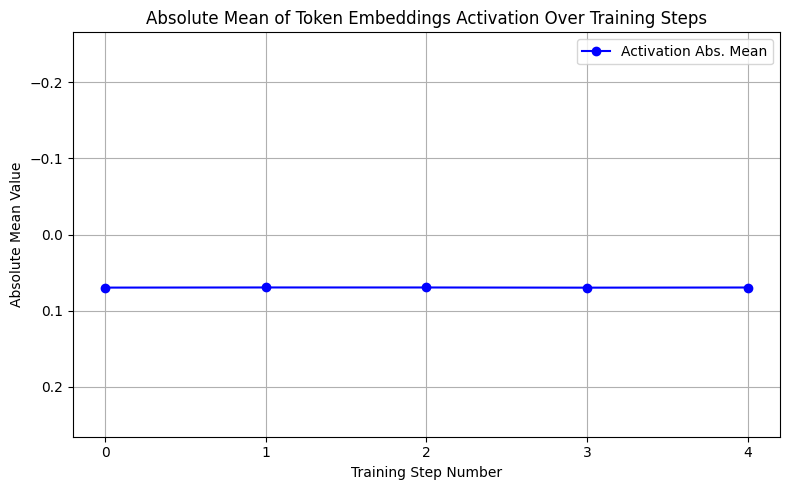

In [10]:
train_steps = np.arange(len(token_embeddings['abs.mean']))

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(train_steps, token_embeddings['abs.mean'], marker='o', linestyle='-', color='b', label='Activation Abs. Mean')

# Add labels and a title
plt.title('Absolute Mean of Token Embeddings Activation Over Training Steps')
plt.xlabel('Training Step Number')
plt.ylabel('Absolute Mean Value')
plt.xticks(train_steps) # Ensure integer ticks on the x-axis
plt.legend()
plt.grid(True)
plt.ylim(max(token_embeddings['max']), min(token_embeddings['min']))

# Show the plot
plt.tight_layout()
plt.show()

plt.close()

## Attention Output Check

Key in the `probe.jsonl` file is `FSDPMupTransformer.layers.{}.attention.wo::out`

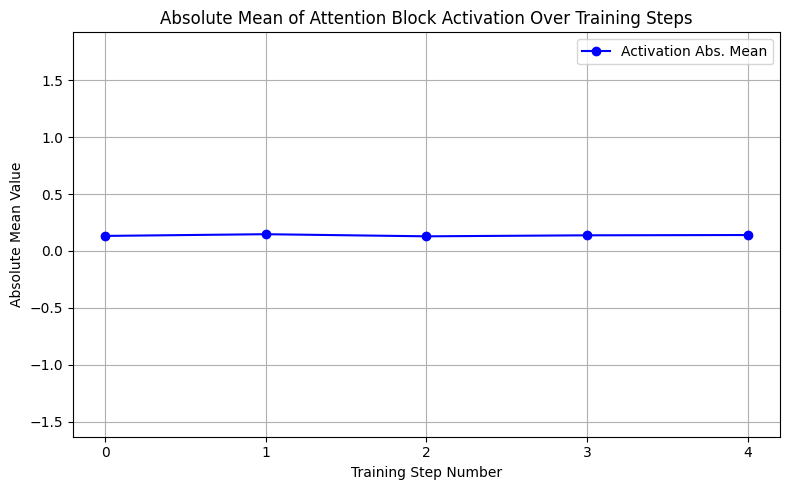

In [56]:
attention_block_output = defaultdict(list)

# We will collect the true max and min values across all layers for each step
all_max_values_per_step = []
all_min_values_per_step = []

for train_step_num in range(len(datas)):
    layer_abs_means = []
    layer_maxes = []
    layer_mins = []
    for layer in range(NUM_LAYERS):
        data = datas[train_step_num]['data'][f'FSDPMupTransformer.layers.{layer}.attention.wo::out']
        layer_abs_means.append(data['abs.mean'])
        layer_maxes.append(data['max'])
        layer_mins.append(data['min'])
        
    # Correctly append the average of the absolute means
    attention_block_output['abs.mean'].append(np.mean(layer_abs_means))
    
    # Correctly append the maximum of all maxes and minimum of all mins for this step
    all_max_values_per_step.append(max(layer_maxes))
    all_min_values_per_step.append(min(layer_mins))
    
train_steps = np.arange(len(attention_block_output['abs.mean']))

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(train_steps, attention_block_output['abs.mean'], marker='o', linestyle='-', color='b', label='Activation Abs. Mean')

# Add labels and a title
plt.title('Absolute Mean of Attention Block Activation Over Training Steps')
plt.xlabel('Training Step Number')
plt.ylabel('Absolute Mean Value')
plt.xticks(train_steps) # Ensure integer ticks on the x-axis
plt.legend()
plt.grid(True)

# Set the y-axis limits using the correctly collected min and max values.
# This ensures the plot is not inverted and shows the full range of activation.
final_max_y = max(all_max_values_per_step)
final_min_y = min(all_min_values_per_step)
plt.ylim(final_min_y, final_max_y)

# Show the plot
plt.tight_layout()
plt.show()

plt.close()

## MLP Output Check

Key in the `probe.jsonl` file is `FSDPMupTransformer.layers.{}.feed_forward.w2::out`

In [34]:
for train_step_num in range(len(datas)):
    for layer in range(NUM_LAYERS):
        print(datas[train_step_num]['data'][f'FSDPMupTransformer.layers.{layer}.feed_forward.w2::out']['abs.mean'])
    print("-")

0.22406908869743347
0.22741813957691193
-
0.22545167803764343
0.21901613473892212
-
0.229436993598938
0.2328483909368515
-
0.22200244665145874
0.22479002177715302
-
0.22452649474143982
0.22719800472259521
-


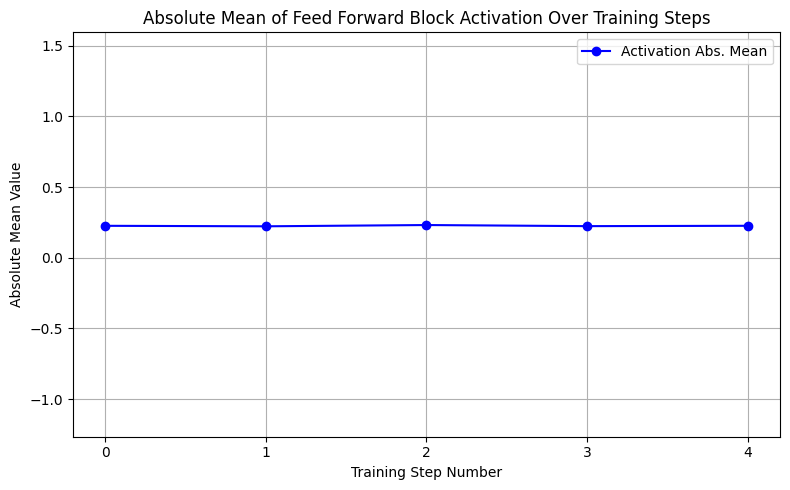

In [54]:
feed_forward_output = defaultdict(list)
all_max_values_per_step = []
all_min_values_per_step = []

for train_step_num in range(len(datas)):
    layer_abs_means = []
    layer_maxes = []
    layer_mins = []
    for layer in range(NUM_LAYERS):
        data_point = datas[train_step_num]['data'][f'FSDPMupTransformer.layers.{layer}.feed_forward.w2::out']
        layer_abs_means.append(data_point['abs.mean'])
        layer_maxes.append(data_point['max'])
        layer_mins.append(data_point['min'])
    
    # Correctly append the average of the absolute means
    feed_forward_output['abs.mean'].append(np.mean(layer_abs_means))
    
    # Correctly append the max of all maxes and min of all mins for the step
    all_max_values_per_step.append(max(layer_maxes))
    all_min_values_per_step.append(min(layer_mins))


train_steps = np.arange(len(feed_forward_output['abs.mean']))

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(train_steps, feed_forward_output['abs.mean'], marker='o', linestyle='-', color='b', label='Activation Abs. Mean')

# Add labels and a title
plt.title('Absolute Mean of Feed Forward Block Activation Over Training Steps')
plt.xlabel('Training Step Number')
plt.ylabel('Absolute Mean Value')
plt.xticks(train_steps) # Ensure integer ticks on the x-axis
plt.legend()
plt.grid(True)

# Set the y-axis limits using the correctly collected min and max values.
# The `max` of all maxes is the upper bound, and the `min` of all mins is the lower bound.
# We will use this to set the ylim in the correct order.
final_max_y = max(all_max_values_per_step)
final_min_y = min(all_min_values_per_step)
plt.ylim(final_min_y, final_max_y)

# Show the plot
plt.tight_layout()
plt.show()

## LM Head Check

Key in the `probe.jsonl` file is `FSDPMupTransformer.output::out`

In [35]:
for train_step_num in range(len(datas)):
    print(datas[train_step_num]['data'][f'FSDPMupTransformer.output::out']['abs.mean'])

0.7872641086578369
0.7871861457824707
0.787097692489624
0.7870625853538513
0.7871651649475098


## Combining all the plots into a single figure

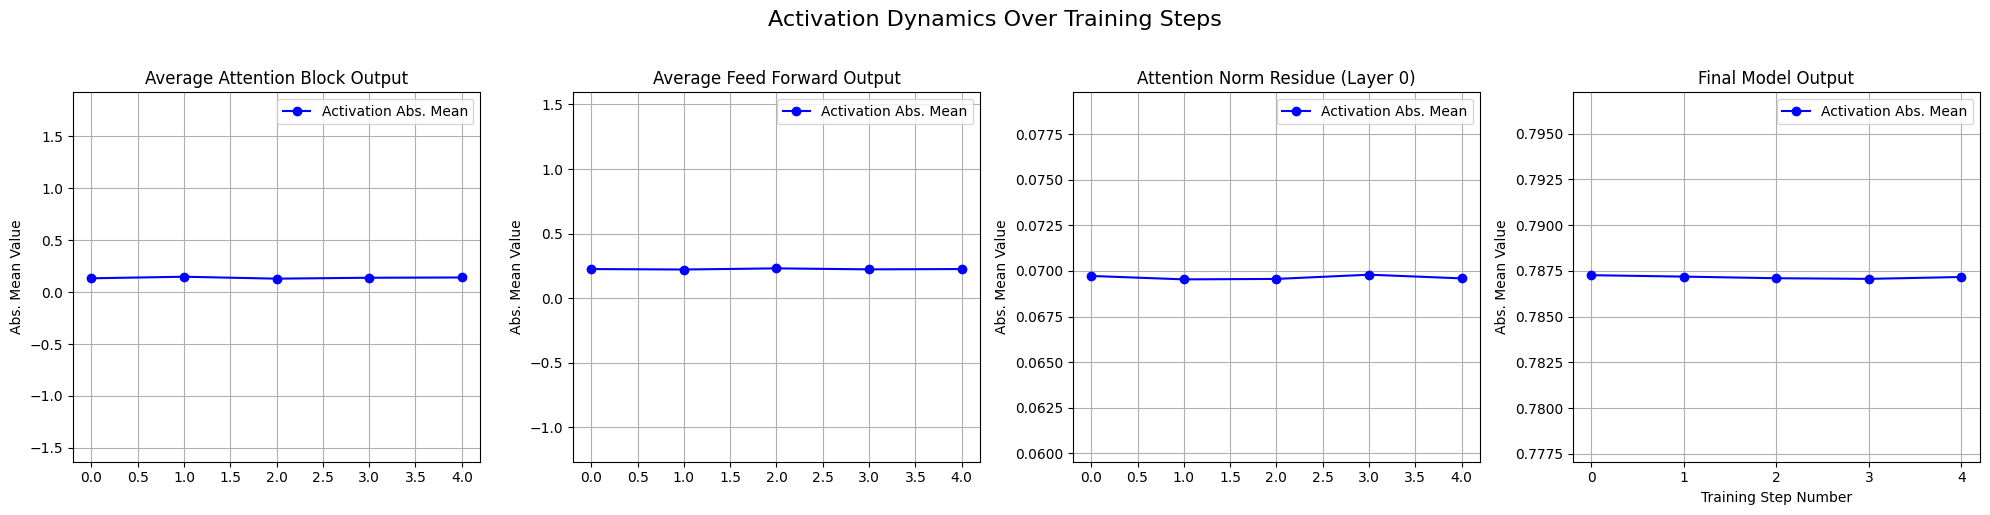

In [11]:
# Helper function to collect data for a given activation path
def collect_activation_data(activation_path_template, average_over_layers=False):
    """
    Collects absolute mean, max, and min values for a given activation path.
    If average_over_layers is True, it averages values across all layers.
    """
    abs_means = []
    maxes = []
    mins = []
    for train_step_num in range(len(datas)):
        if average_over_layers:
            layer_abs_means = []
            layer_maxes = []
            layer_mins = []
            for layer in range(NUM_LAYERS):
                data_point = datas[train_step_num]['data'][activation_path_template.format(layer=layer)]
                layer_abs_means.append(data_point['abs.mean'])
                layer_maxes.append(data_point['max'])
                layer_mins.append(data_point['min'])
            
            abs_means.append(np.mean(layer_abs_means))
            maxes.append(max(layer_maxes))
            mins.append(min(layer_mins))
        else:
            # Single value per step, no layer loop needed
            data_point = datas[train_step_num]['data'][activation_path_template]
            abs_means.append(data_point['abs.mean'])
            if 'max' in data_point:
                maxes.append(data_point['max'])
            if 'min' in data_point:
                mins.append(data_point['min'])
    return abs_means, maxes, mins

# Define the plots to be generated
plot_info = [
    {
        'path': 'FSDPMupTransformer.layers.{layer}.attention.wo::out',
        'title': 'Average Attention Block Output',
        'avg_layers': True
    },
    {
        'path': 'FSDPMupTransformer.layers.{layer}.feed_forward.w2::out',
        'title': 'Average Feed Forward Output',
        'avg_layers': True
    },
    {
        'path': 'FSDPMupTransformer.layers.0.attention_norm::resid',
        'title': 'Attention Norm Residue (Layer 0)',
        'avg_layers': False
    },
    {
        'path': 'FSDPMupTransformer.output::out',
        'title': 'Final Model Output',
        'avg_layers': False
    }
]

# Set up the subplot grid
fig, axes = plt.subplots(nrows=1, ncols=len(plot_info), figsize=(20, 5), sharey=False)
fig.suptitle('Activation Dynamics Over Training Steps', fontsize=16, y=1.02)
train_steps = np.arange(len(datas))

# Generate each plot
for i, info in enumerate(plot_info):
    ax = axes[i]
    abs_means, maxes, mins = collect_activation_data(info['path'], info['avg_layers'])
    
    ax.plot(train_steps, abs_means, marker='o', linestyle='-', color='b', label='Activation Abs. Mean')
    
    ax.set_title(info['title'])
    ax.set_ylabel('Abs. Mean Value')
    ax.grid(True)
    ax.legend(loc='upper right')

    # Set appropriate y-limits based on the collected data
    if info['avg_layers']:
        ax.set_ylim(min(mins), max(maxes))
    else:
        # For non-averaged plots, just use the abs_means values themselves
        ax.set_ylim(min(abs_means) - 0.01, max(abs_means) + 0.01)

# Set the final x-axis properties
axes[-1].set_xlabel('Training Step Number')
axes[-1].set_xticks(train_steps)

plt.tight_layout()
plt.show()

plt.close()

Loading data from StringIO (simulated file content).
Loading data from StringIO (simulated file content).
Loading data from StringIO (simulated file content).
Loading data from StringIO (simulated file content).
Loading data from StringIO (simulated file content).
Loading data from StringIO (simulated file content).


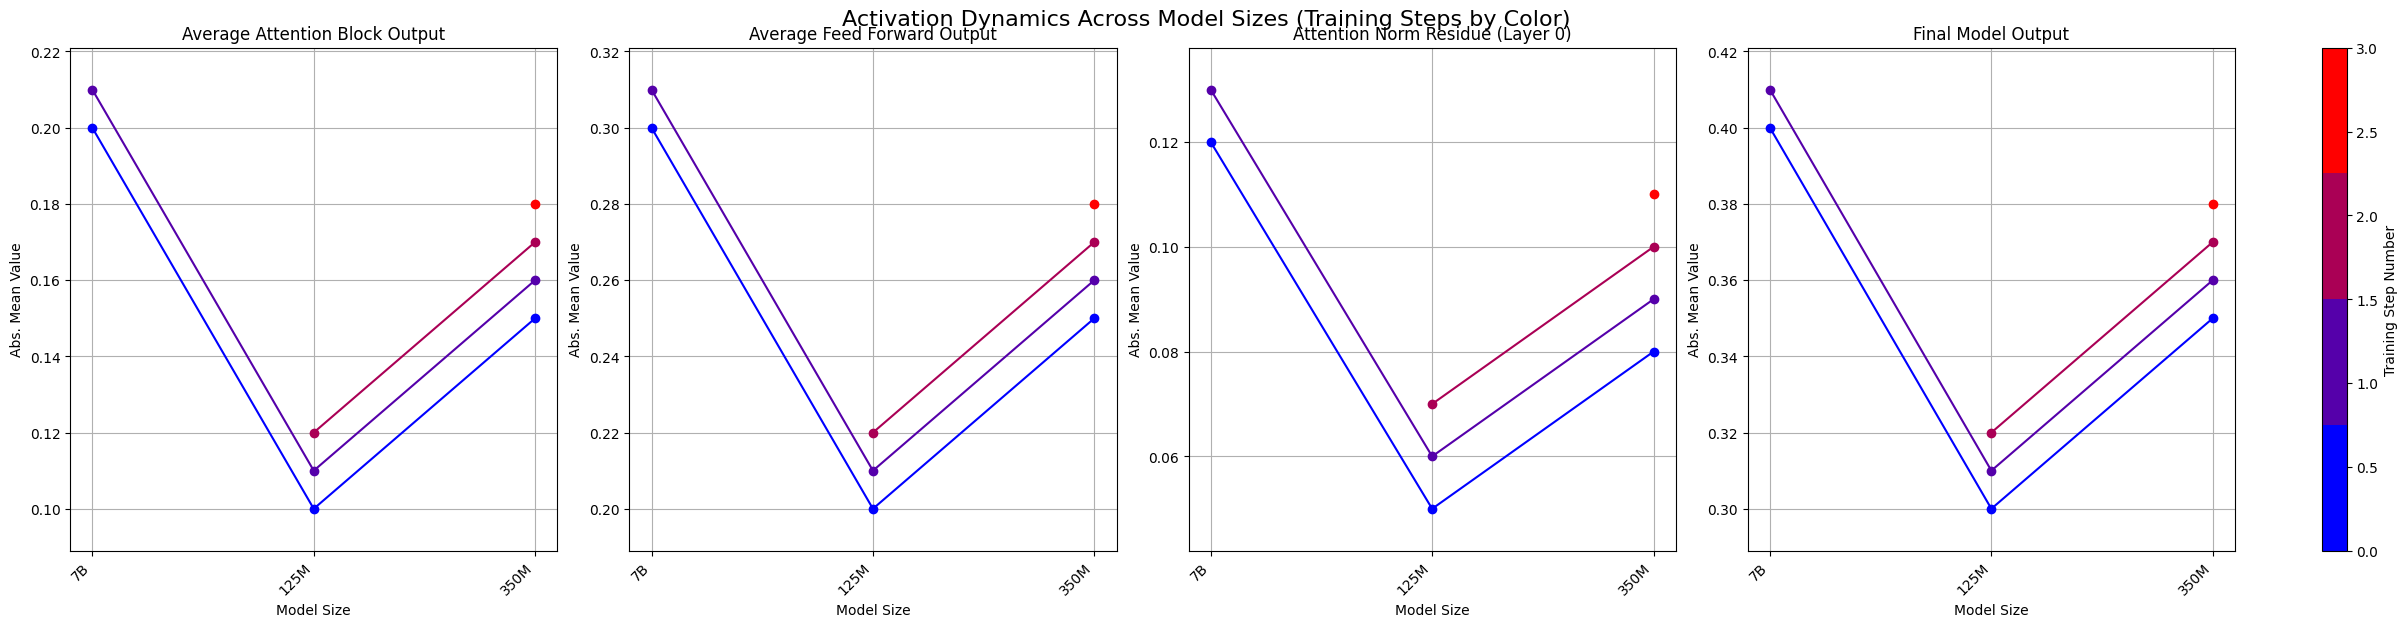

In [1]:
import math
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib
from matplotlib import rc
from collections import defaultdict
import io # For simulating file input
from typing import Union, Dict, Any
import matplotlib.cm as cm # For colormaps
from matplotlib.colors import LinearSegmentedColormap, Normalize # For custom colormaps and normalization

# --- Configuration ---
DEFAULT_QUANTILES = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]

# Define the plots to be generated, similar to before.
# These will be the individual subplots.
PLOT_DEFINITIONS = [
    {
        'path': 'FSDPMupTransformer.layers.{layer}.attention.wo::out',
        'title': 'Average Attention Block Output',
        'avg_layers': True
    },
    {
        'path': 'FSDPMupTransformer.layers.{layer}.feed_forward.w2::out',
        'title': 'Average Feed Forward Output',
        'avg_layers': True
    },
    {
        'path': 'FSDPMupTransformer.layers.0.attention_norm::resid',
        'title': 'Attention Norm Residue (Layer 0)',
        'avg_layers': False
    },
    {
        'path': 'FSDPMupTransformer.output::out',
        'title': 'Final Model Output',
        'avg_layers': False
    }
]

# --- Data Loading and Preprocessing Functions ---
def load_and_preprocess_probe_data_flexible(
    probe_source: Union[Path, io.StringIO], default_quantiles: list
) -> tuple[list[dict], int]:
    """
    Loads probe data from a specified source (Path to folder or StringIO object),
    preprocesses it, and deduces the number of layers from the data.

    Args:
        probe_source: Path to the folder containing the probe JSON file (e.g., 'probe.json'
                      or 'probe/probe.0.jsonl'), or a StringIO object containing
                      the JSONL content.
        default_quantiles: List of default quantiles to set if not present in data entries.

    Returns:
        A tuple containing:
        - processed_datas: List of dictionaries, where each dictionary is a preprocessed
                           data point for a specific training step.
        - num_layers: The deduced number of layers in the model based on data keys.

    Raises:
        FileNotFoundError: If the probe JSON file cannot be found in the specified path.
        ValueError: If no valid data entries are found or if the model depth cannot be deduced.
        TypeError: If probe_source is neither a Path nor a StringIO object.
    """
    if isinstance(probe_source, Path):
        print(f"Attempting to load data from folder: {probe_source.name}")
        file_path = None
        # Check for common probe file names
        for probe_test_file in ["probe/probe.0.jsonl", "probe.json"]:
            candidate_path = probe_source / probe_test_file
            if (probe_source / probe_test_file).exists():
                file_path = probe_source / probe_test_file
                break

        if file_path is None:
            raise FileNotFoundError(f"Could not find probe JSON file in {probe_source}")
        raw_data = file_path.read_text()
    elif isinstance(probe_source, io.StringIO):
        print("Loading data from StringIO (simulated file content).")
        raw_data = probe_source.getvalue()
    else:
        raise TypeError("probe_source must be a pathlib.Path object or an io.StringIO object.")

    processed_datas = []
    for line in raw_data.splitlines():
        if line.strip() == "":
            continue
        try:
            data_entry = json.loads(line)
            data_entry.setdefault("quantiles", default_quantiles)
            data_entry["meta"]["it"] = data_entry["meta"]["global_step"]
            processed_datas.append(data_entry)
        except json.JSONDecodeError as e:
            print(f"Warning: Could not parse JSON line: {line[:100]}... Error: {e}")
            continue

    if not processed_datas:
        raise ValueError(f"No valid data entries found in {probe_source}. Check file content.")

    num_layers = 0
    layer_keys = [
        k for k in processed_datas[0]["data"].keys()
        if k.startswith("FSDPMupTransformer.layers.") and k.endswith("::w")
    ]
    if layer_keys:
        max_layer_idx = max(
            int(k.split("FSDPMupTransformer.layers.", 1)[1].split(".")[0])
            for k in layer_keys
        )
        num_layers = max_layer_idx + 1
    else:
        raise ValueError("Couldn't deduce the model depth from data keys. Check data format.")

    return processed_datas, num_layers

# --- Data Aggregation for Scaling Plots ---
def collect_scaling_data(
    all_model_datas: Dict[str, list[dict]], # Key: model_size_label, Value: list of data entries
    plot_definitions: list[dict]
) -> Dict[str, Dict[str, Dict[int, float]]]:
    """
    Collects activation 'abs.mean' data for each plot definition, across all model sizes
    and training steps, structured for scaling plots.

    Args:
        all_model_datas: A dictionary where keys are model size labels (e.g., "125M", "350M")
                         and values are lists of preprocessed data dictionaries for that model.
        plot_definitions: A list of dictionaries, each defining a plot.

    Returns:
        A nested dictionary:
        {
            'plot_path_key_1': {
                'model_size_label_1': {
                    training_step_0: abs_mean_value,
                    training_step_1: abs_mean_value,
                    ...
                },
                'model_size_label_2': { ... },
            },
            'plot_path_key_2': { ... },
            ...
        }
        Returns np.nan for missing data points.
    """
    scaling_data = defaultdict(lambda: defaultdict(dict))

    for model_size_label, datas_for_model in all_model_datas.items():
        # Deduce num_layers for the current model, as it might vary by model size
        # This assumes the first data entry is representative for layer deduction.
        try:
            _, num_layers = load_and_preprocess_probe_data_flexible(
                io.StringIO(json.dumps(datas_for_model[0])), DEFAULT_QUANTILES
            )
        except (ValueError, TypeError):
            # If layer deduction fails for a model, assume 0 layers for this model's processing
            # This might lead to issues if avg_layers is True for paths that require layers.
            # A more robust solution might be to skip this model entirely for layer-averaged plots.
            num_layers = 0
            print(f"Warning: Could not deduce layers for model {model_size_label}. Averaging over layers might fail.")

        for info in plot_definitions:
            plot_key = info['path'] # Use the path as a key for the outer dictionary

            abs_means_for_path = []
            maxes_for_path = []
            mins_for_path = []

            # Collect data for this path across all training steps for the current model
            # This logic is similar to the original collect_activation_metrics, but
            # it's now nested within the model loop.
            for train_step_data in datas_for_model:
                current_step = train_step_data['meta']['it']
                if info['avg_layers']:
                    layer_abs_means = []
                    for layer_idx in range(num_layers):
                        path_with_layer = info['path'].format(layer=layer_idx)
                        if path_with_layer in train_step_data['data']:
                            layer_abs_means.append(train_step_data['data'][path_with_layer]['abs.mean'])
                    # If no layers contributed data, result is NaN for this step
                    avg_abs_mean = np.mean(layer_abs_means) if layer_abs_means else np.nan
                else:
                    if info['path'] in train_step_data['data']:
                        avg_abs_mean = train_step_data['data'][info['path']]['abs.mean']
                    else:
                        avg_abs_mean = np.nan # Data missing for this path/step

                scaling_data[plot_key][model_size_label][current_step] = avg_abs_mean
    return scaling_data

# --- Plotting Function for Scaling Plots ---
def generate_scaling_plots(
    probe_folders_and_labels: Dict[str, Union[Path, io.StringIO]], # {label: path/StringIO}
    plot_definitions: list[dict],
    default_quantiles: list
):
    """
    Generates plots showing activation dynamics across different model sizes,
    with training steps encoded by color.

    Args:
        probe_folders_and_labels: A dictionary where keys are descriptive labels for model sizes
                                  (e.g., "125M", "350M") and values are Path objects to the
                                  probe data folders or StringIO objects for simulation.
        plot_definitions: A list of dictionaries, each defining a plot.
        default_quantiles: Default quantiles to be used during data loading.
    """
    #rc("animation", html="jshtml")
    # Removed matplotlib.use('Agg') to allow interactive plotting in environments like Jupyter.

    all_model_datas = {}
    all_training_steps = set() # To collect all unique training steps across all models
    model_sizes_ordered = [] # To maintain the order of model sizes on the x-axis

    # Load data for all models
    for label, probe_source in probe_folders_and_labels.items():
        try:
            datas_for_model, _ = load_and_preprocess_probe_data_flexible(
                probe_source, default_quantiles
            )
            all_model_datas[label] = datas_for_model
            model_sizes_ordered.append(label) # Add label to ordered list

            # Collect all unique training steps
            for data_entry in datas_for_model:
                all_training_steps.add(data_entry['meta']['it'])
        except (FileNotFoundError, ValueError, TypeError) as e:
            print(f"Error loading data for model '{label}': {e}. Skipping this model.")
            continue

    if not all_model_datas:
        print("No valid model data loaded. Cannot generate plots.")
        return

    # Sort model sizes if they are numeric, otherwise use the order they were provided
    try:
        # Attempt to sort numerically if labels are convertible to numbers
        model_sizes_ordered.sort(key=lambda x: float(''.join(filter(str.isdigit, x))))
    except ValueError:
        # If not numeric, keep the insertion order or sort alphabetically
        model_sizes_ordered.sort() # Sort alphabetically as a fallback

    # Ensure training steps are sorted for consistent color mapping
    sorted_training_steps = sorted(list(all_training_steps))
    if not sorted_training_steps:
        print("No training steps found across all models. Cannot generate plots.")
        return

    # Create a colormap from blue to red for training steps
    # We'll use a custom colormap for a more direct blue-to-red transition.
    colors = ["blue", "red"]
    cmap_name = "BlueRed"
    cm_blue_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sorted_training_steps))
    # Normalize the training steps to map them to the 0-1 range of the colormap
    norm = Normalize(vmin=min(sorted_training_steps), vmax=max(sorted_training_steps))

    # Collect all data structured for scaling plots
    scaling_data = collect_scaling_data(all_model_datas, plot_definitions)

    # Set up the subplot grid with constrained_layout to prevent label overlap.
    fig, axes = plt.subplots(
        nrows=1, ncols=len(plot_definitions), figsize=(6 * len(plot_definitions), 6),
        sharey=False, constrained_layout=True
    )
    fig.suptitle('Activation Dynamics Across Model Sizes (Training Steps by Color)', fontsize=16, y=1.02)

    if len(plot_definitions) == 1:
        axes = [axes]

    # Iterate through each plot definition and generate the scaling plot
    for i, info in enumerate(plot_definitions):
        ax = axes[i]
        plot_key = info['path']
        ax.set_title(info['title'])
        ax.set_xlabel('Model Size')
        ax.set_ylabel('Abs. Mean Value')
        ax.grid(True)

        # Collect all y-values for this subplot to determine overall y-limits
        all_y_values_for_subplot = []

        # Plot a line for each training step
        for step_idx, training_step in enumerate(sorted_training_steps):
            abs_mean_values_for_step = []
            for model_size_label in model_sizes_ordered:
                # Get the absolute mean value for the current model size and training step
                # Use .get() with np.nan as default if data is missing for a specific model/step
                value = scaling_data[plot_key][model_size_label].get(training_step, np.nan)
                abs_mean_values_for_step.append(value)

            # Filter out NaNs for plotting, but keep the length consistent for x-axis
            plot_x = np.arange(len(model_sizes_ordered))
            plot_y = np.array(abs_mean_values_for_step)
            valid_indices = ~np.isnan(plot_y)

            if np.any(valid_indices):
                # Get color based on training step
                color = cm_blue_red(norm(training_step))
                ax.plot(plot_x[valid_indices], plot_y[valid_indices],
                        marker='o', linestyle='-', color=color,
                        label=f'Step {training_step}')
                all_y_values_for_subplot.extend(plot_y[valid_indices])

        # Set x-axis ticks and labels
        ax.set_xticks(np.arange(len(model_sizes_ordered)))
        ax.set_xticklabels(model_sizes_ordered, rotation=45, ha='right')

        # Set y-limits based on all collected data for this subplot
        if all_y_values_for_subplot:
            ymin = np.min(all_y_values_for_subplot)
            ymax = np.max(all_y_values_for_subplot)
            buffer = (ymax - ymin) * 0.1 if (ymax - ymin) > 0 else 0.01
            ax.set_ylim(ymin - buffer, ymax + buffer)
        else:
            ax.set_ylim(0, 1) # Default arbitrary range if no data

    # Add a colorbar to the figure to indicate training step mapping
    # Create a dummy mappable object for the colorbar
    sm = cm.ScalarMappable(cmap=cm_blue_red, norm=norm)
    sm.set_array([]) # Required for scalar mappable
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Training Step Number')

    # plt.tight_layout() is not needed with constrained_layout
    plt.show()
    plt.close(fig)

# --- Main Execution Block for Demonstration ---

# Simulate probe data for different model sizes and multiple training steps
# Each string represents the content of a probe.jsonl file for a given model size.

# Model 1: "125M"
dummy_data_125m = """
{"meta": {"global_step": 0}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.1, "max": 0.5, "min": -0.5}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.12, "max": 0.6, "min": -0.6}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.2, "max": 0.7, "min": -0.7}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.22, "max": 0.8, "min": -0.8}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.05, "max": 0.2, "min": -0.2}, "FSDPMupTransformer.output::out": {"abs.mean": 0.3, "max": 1.0, "min": -1.0}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 1}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.11, "max": 0.55, "min": -0.55}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.13, "max": 0.65, "min": -0.65}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.21, "max": 0.75, "min": -0.75}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.23, "max": 0.85, "min": -0.85}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.06, "max": 0.22, "min": -0.22}, "FSDPMupTransformer.output::out": {"abs.mean": 0.31, "max": 1.05, "min": -1.05}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 2}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.12, "max": 0.6, "min": -0.6}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.14, "max": 0.7, "min": -0.7}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.22, "max": 0.8, "min": -0.8}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.24, "max": 0.9, "min": -0.9}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.07, "max": 0.24, "min": -0.24}, "FSDPMupTransformer.output::out": {"abs.mean": 0.32, "max": 1.1, "min": -1.1}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
"""

# Model 2: "350M" - Simulating slightly different values and more steps
dummy_data_350m = """
{"meta": {"global_step": 0}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.15, "max": 0.6, "min": -0.6}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.17, "max": 0.7, "min": -0.7}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.25, "max": 0.8, "min": -0.8}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.27, "max": 0.9, "min": -0.9}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.08, "max": 0.25, "min": -0.25}, "FSDPMupTransformer.output::out": {"abs.mean": 0.35, "max": 1.1, "min": -1.1}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 1}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.16, "max": 0.62, "min": -0.62}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.18, "max": 0.72, "min": -0.72}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.26, "max": 0.82, "min": -0.82}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.28, "max": 0.92, "min": -0.92}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.09, "max": 0.26, "min": -0.26}, "FSDPMupTransformer.output::out": {"abs.mean": 0.36, "max": 1.12, "min": -1.12}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 2}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.17, "max": 0.64, "min": -0.64}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.19, "max": 0.74, "min": -0.74}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.27, "max": 0.84, "min": -0.84}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.29, "max": 0.94, "min": -0.94}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.10, "max": 0.27, "min": -0.27}, "FSDPMupTransformer.output::out": {"abs.mean": 0.37, "max": 1.14, "min": -1.14}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 3}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.18, "max": 0.66, "min": -0.66}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.20, "max": 0.76, "min": -0.76}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.28, "max": 0.86, "min": -0.86}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.30, "max": 0.96, "min": -0.96}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.11, "max": 0.28, "min": -0.28}, "FSDPMupTransformer.output::out": {"abs.mean": 0.38, "max": 1.16, "min": -1.16}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
"""

# Model 3: "7B" - Simulating more layers and different values
dummy_data_7b = """
{"meta": {"global_step": 0}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.2, "max": 0.7, "min": -0.7}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.22, "max": 0.8, "min": -0.8}, "FSDPMupTransformer.layers.2.attention.wo::out": {"abs.mean": 0.24, "max": 0.9, "min": -0.9}, "FSDPMupTransformer.layers.3.attention.wo::out": {"abs.mean": 0.26, "max": 1.0, "min": -1.0}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.3, "max": 1.0, "min": -1.0}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.32, "max": 1.1, "min": -1.1}, "FSDPMupTransformer.layers.2.feed_forward.w2::out": {"abs.mean": 0.34, "max": 1.2, "min": -1.2}, "FSDPMupTransformer.layers.3.feed_forward.w2::out": {"abs.mean": 0.36, "max": 1.3, "min": -1.3}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.12, "max": 0.3, "min": -0.3}, "FSDPMupTransformer.output::out": {"abs.mean": 0.4, "max": 1.2, "min": -1.2}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
{"meta": {"global_step": 1}, "data": {"FSDPMupTransformer.layers.0.attention.wo::out": {"abs.mean": 0.21, "max": 0.72, "min": -0.72}, "FSDPMupTransformer.layers.1.attention.wo::out": {"abs.mean": 0.23, "max": 0.82, "min": -0.82}, "FSDPMupTransformer.layers.2.attention.wo::out": {"abs.mean": 0.25, "max": 0.92, "min": -0.92}, "FSDPMupTransformer.layers.3.attention.wo::out": {"abs.mean": 0.27, "max": 1.02, "min": -1.02}, "FSDPMupTransformer.layers.0.feed_forward.w2::out": {"abs.mean": 0.31, "max": 1.02, "min": -1.02}, "FSDPMupTransformer.layers.1.feed_forward.w2::out": {"abs.mean": 0.33, "max": 1.12, "min": -1.12}, "FSDPMupTransformer.layers.2.feed_forward.w2::out": {"abs.mean": 0.35, "max": 1.22, "min": -1.22}, "FSDPMupTransformer.layers.3.feed_forward.w2::out": {"abs.mean": 0.37, "max": 1.32, "min": -1.32}, "FSDPMupTransformer.layers.0.attention_norm::resid": {"abs.mean": 0.13, "max": 0.31, "min": -0.31}, "FSDPMupTransformer.output::out": {"abs.mean": 0.41, "max": 1.22, "min": -1.22}, "FSDPMupTransformer.layers.0.attention.wo::w": {}}}
"""

# Create StringIO objects for simulation
simulated_probe_folders = {
    "125M": io.StringIO(dummy_data_125m),
    "350M": io.StringIO(dummy_data_350m),
    "7B": io.StringIO(dummy_data_7b), # Example with more layers
}

# To run with your actual files, you would replace `io.StringIO` with `Path` objects:
# actual_probe_folders = {
#     "125M": Path("/path/to/125M_model_probe_data/"),
#     "350M": Path("/path/to/350M_model_probe_data/"),
#     "7B": Path("/path/to/7B_model_probe_data/"),
# }

    # Call the new plotting function
    
generate_scaling_plots(simulated_probe_folders, PLOT_DEFINITIONS, DEFAULT_QUANTILES)
